In [ ]:
import pandas as pd
import re
import numpy as np
from collections import Counter, defaultdict
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
import os
import tensorflow as tf
import torch
from torch.nn.utils.rnn import pad_sequence
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors
import string
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/

/content/drive/MyDrive


In [ ]:
#Acquire the dataset from AllReviews csv file and clean it up to a usable form
AllReviews = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AllReviews.csv')
AllReviews = AllReviews.loc[(AllReviews["titleType"] == "tvMovie")|(AllReviews["titleType"] == "movie")]

# Filter relevant columns and remove duplicates
Reviews_Genres_Title = AllReviews[["Review", "genres"]].drop_duplicates()
# Remove rows with missing reviews
Reviews_Genres_Title = Reviews_Genres_Title.dropna(subset=["Review"])
# Remove rows with undefined genres
Reviews_Genres_Title = Reviews_Genres_Title[Reviews_Genres_Title["genres"] != '\\N']

# Copy for further processing
Complete_Reviews = Reviews_Genres_Title.copy()
# Convert reviews to lowercase
Complete_Reviews['Review'] = Complete_Reviews['Review'].str.lower()
# Replace periods and commas
Complete_Reviews['Review'] = Complete_Reviews['Review'].str.replace('[,.]', ' ', regex=True)
# Remove newlines
Complete_Reviews['Review'] = Complete_Reviews['Review'].str.replace('\n', '', regex=False)
# Remove HTML tags
Complete_Reviews['Review'] = Complete_Reviews['Review'].str.replace('<[^>]+>', '', regex=True)
# Remove non-alphanumeric characters
Complete_Reviews['Review'] = Complete_Reviews['Review'].str.replace('[^A-Za-z0-9 ]+', '', regex=True)
Complete_Reviews.reset_index(drop=True, inplace=True)

In [ ]:
# DistilGPT2 pretrained
#New_Reviews = pd.read_csv('/content/drive/MyDrive/results/distilgpt_reviews.csv')
# DistilGPT2 finetuned
#New_Reviews = pd.read_csv('/content/drive/MyDrive/results/distilgpt_finetuned_reviews.csv')
# GRU Reviews
#New_Reviews = pd.read_csv('/content/drive/MyDrive/results/GRU_GenReviews (1).csv')
# Unigram Reviews
#New_Reviews = pd.read_csv('/content/drive/MyDrive/results/unigram_reviews.csv')
# Bigram Reviews
#New_Reviews = pd.read_csv('/content/drive/MyDrive/results/bigram_reviews.csv')
# Trigram Reviews
#New_Reviews = pd.read_csv('/content/drive/MyDrive/results/trigram_reviews.csv')

New_Reviews = New_Reviews.rename(str.lower, axis='columns')

# Remove Prompt - DistilGPT2
New_Reviews['review'] = New_Reviews['review'].str.replace('^write a movie review:', '', regex=True)
# Remove Prompt - GRU
New_Reviews['review'] = New_Reviews['review'].str.replace('^and then ', '', regex=True)
# Convert reviews to lowercase
New_Reviews['review'] = New_Reviews['review'].str.lower()
# Replace periods and commas
New_Reviews['review'] = New_Reviews['review'].str.replace('[,.]', ' ', regex=True)
# Remove newlines
New_Reviews['review'] = New_Reviews['review'].str.replace('\n', '', regex=False)
# Remove HTML tags
New_Reviews['review'] = New_Reviews['review'].str.replace('<[^>]+>', '', regex=True)
# Remove non-alphanumeric characters
New_Reviews['review'] = New_Reviews['review'].str.replace('[^A-Za-z0-9 ]+', '', regex=True)

fake_reviews = pd.DataFrame({'Review': New_Reviews['review'], 'Label': 'fake'})

In [ ]:
# Randomly select an equal number of real reviews for classification training
points = np.random.choice(list(range(Complete_Reviews.shape[0])), size = fake_reviews.shape[0], replace = False)
real_reviews = Complete_Reviews['Review'][points]
real_reviews = pd.DataFrame({'Review': real_reviews, 'Label': 'real'})

In [ ]:
reviews = pd.concat([real_reviews, fake_reviews]).reset_index(drop=True)
reviews = reviews.sample(frac=1, random_state=42).reset_index(drop=True)
reviews

,Review,Label
0,thats marvelously idea picture dawson the is t...,fake
1,slightly dangerous gave 21 yearold lana turner...,real
2,the film reminds me of two other films marty ...,real
3,from what ive read a lot of people were disapp...,real
4,this seems like one of those movies that we th...,real
...,...,...
9995,to with sown his not deerfield them every fort...,fake
9996,first how not all bother thrilled embroiled i ...,fake
9997,it a the it to killed survive zina of charlene...,fake
9998,out of starslets see 14 divided by 20 time...,real


In [ ]:
all_data = reviews['Review']
all_labels = reviews['Label']

vectorizer = TfidfVectorizer()
all_data = vectorizer.fit_transform(all_data)

split_point = 0.8
X_train, X_test, y_train, y_test = train_test_split(
    all_data, all_labels, train_size = split_point)


In [ ]:
def get_confusion_matrix(test_labels, pred_labels):
    sns.set()
    mat = confusion_matrix(test_labels, pred_labels)
    plt.figure(figsize=(5,5))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label')

def get_f1_scores(test_labels, pred_labels):
    f1 = f1_score(test_labels, pred_labels, pos_label = 'real')
    print("F1 Score:", round(100*f1, 2), "%")


F1 Score: 89.89 %


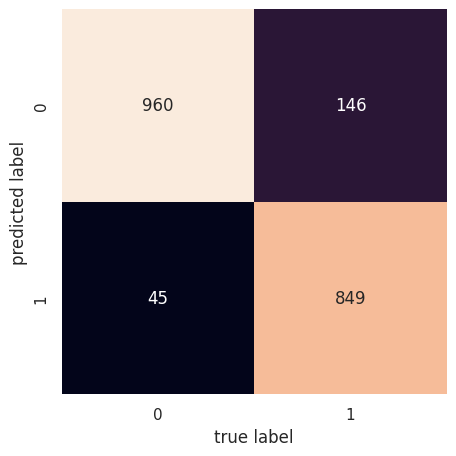

In [ ]:
# Train the model
lr_model1 = LogisticRegression()
lr_model1.fit(X_train, y_train)

y_pred = lr_model1.predict(X_test)

get_confusion_matrix(y_test, y_pred)
get_f1_scores(y_test, y_pred)

F1 Score: 91.49 %


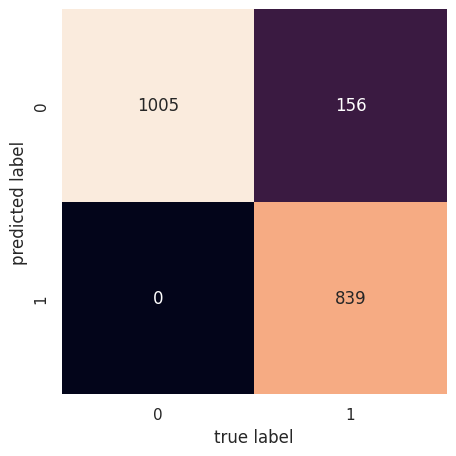

In [ ]:
rf_model2 = RandomForestClassifier()
rf_model2.fit(X_train, y_train)

y_pred = rf_model2.predict(X_test)

get_confusion_matrix(y_test, y_pred)
get_f1_scores(y_test, y_pred)